In [2]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
from DLScommonTools import *
import os
import pickle as pkl
from scipy import interpolate
import scipy as sp
set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2

# Here are some useful labels to use for plotting throughout notebook
store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}

# Overview
This notebook gives an example calculation and visualisation of detachment front location sensitivity, i.e. how fast will the front move through different regions of the domain depending on the magnetic topology. Front movement is proportional to the fractional B field gradient: the sharper the gradient as a proportion of the B field at that point (see Cowley 2022 for more details). This means the sharper the gradient and the lower the B field, the slower the front movement.

# Read and visualise equilibrium
- V10 inner and outer, visualised.

In [26]:
eqb = file_read("eqb_store.pkl")
data = eqb["V10"] # Pick design to use for study

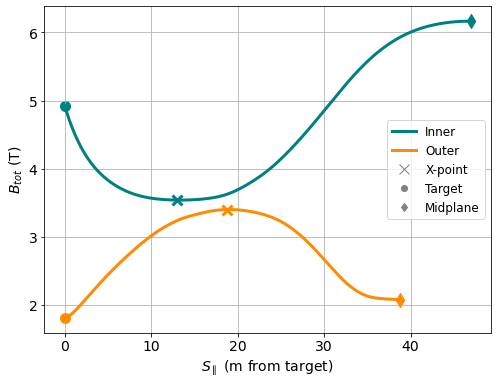

In [27]:
fig, ax = plt.subplots()
colors = mike_cmap(2)
labels = {"ou":"Outer", "iu":"Inner"}
size = 100

for i, side in enumerate(["iu", "ou"]):
    d = data[side]
    Xpoint = d["Xpoint"]
    ax.plot(d["S"], d["Btot"], color = colors[i], label = labels[side])
    ax.scatter(d["S"][Xpoint], d["Btot"][Xpoint], color = colors[i], marker = "x", s = size)
    ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o", s = size)
    ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d", s = size)

ax.set_xlabel("$S_{\parallel}$ (m from target)")
ax.set_ylabel("$B_{tot}$ (T)")
ax.legend()

h,l = ax.get_legend_handles_labels()
extra_handles = [
    mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 10),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target"),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane")]

ax.legend(fontsize = 12, handles = h+extra_handles)

# Run basic density scan on both the inner and the outer

## Set DLS defaults

In [5]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}


## Run
- Running a grid of flux expansion and connection length combinations between Xpoint and target. 
- Note that the inner is set to the same power as the outer here. 
- Reducing the inner power to 10% of the outer like the previous studies leads to numerical issues which are still being investigated.
- Also note that this is using the STEP V10 profiles.

If you don't want to do the run, you can read in the results in the next cell.

In [22]:
store = dict()

design = "V10"

# 
list_BxBt_scales = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])
list_Lc_scales = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])

for side in ["iu", "ou"]:
    print("Running side: {}".format(side))
    result_array = []
    
    for i, BxBt_scale in enumerate(list_BxBt_scales):
        print("Running BxBt scale factor: {:.2f} -- ".format(BxBt_scale), end="")
        result_row = []
        
        for j, Lc_scale in enumerate(list_Lc_scales):
            print("Running Lc scale factor: {:.2f} -- ".format(Lc_scale), end="")
                
            d = copy.deepcopy(eqb[design][side])
            constants = constants_default.copy()
            radios = radios_default.copy()
                              
            d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
            d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
                              
            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            
            # Inner has 10% of the power.
            # if side == "iu":
            #     constants["qpllu0"] = constants_default["qpllu0"] * 0.1
            constants["cz0"] = 0.05
            SparRange = [0, d["S"][d["Xpoint"]-1]]    
            out = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = "density")
            result_row.append(out)

        result_array.append(result_row)
                              
    store[side] = result_array

store["list_BxBt_scales"] = list_BxBt_scales
store["list_Lc_scales"] = list_Lc_scales

Running side: iu
Running BxBt scale factor: 0.25 -- Running Lc scale factor: 0.25 -- Solving...0...110...

C:\Users\Mike\OneDrive\Project\DLS\DLS-mk-git\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Complete in 5.0 seconds
Running Lc scale factor: 0.38 -- Solving...0...110...Complete in 5.3 seconds
Running Lc scale factor: 0.50 -- Solving...0...110...Complete in 5.4 seconds
Running Lc scale factor: 0.62 -- Solving...0...110...Complete in 5.1 seconds
Running Lc scale factor: 0.75 -- Solving...0...110...Complete in 4.8 seconds
Running Lc scale factor: 0.88 -- Solving...0...110...Complete in 5.2 seconds
Running Lc scale factor: 1.00 -- Solving...0...110...Complete in 5.2 seconds
Running Lc scale factor: 1.25 -- Solving...0...110...Complete in 4.3 seconds
Running Lc scale factor: 1.50 -- Solving...0...110...Complete in 4.8 seconds
Running Lc scale factor: 1.75 -- Solving...0...110...Complete in 4.9 seconds
Running Lc scale factor: 2.00 -- Solving...0...110...Complete in 3.8 seconds
Running Lc scale factor: 2.25 -- Solving...0...110...Complete in 4.7 seconds
Running Lc scale factor: 2.50 -- Solving...0...110...Complete in 4.1 seconds
Running BxBt scale factor: 0.38 -- Running Lc scale 

## Read/write

In [23]:
file_write(store, "2dscan_v10_density_kAr.pkl")

In [24]:
store = file_read("2dscan_v10_density_kAr.pkl")

# 2D Contour plot
- X axis: change in connection length
- Y axis: change in flux expansion
- The colour scale indicates threshold improvement (i.e. threshold reduction
- Illustrates nonlinearity in impact of both parameters
- On the inner, there is a "blank" space at the bottom. This illustrates the region of unstable solutions.

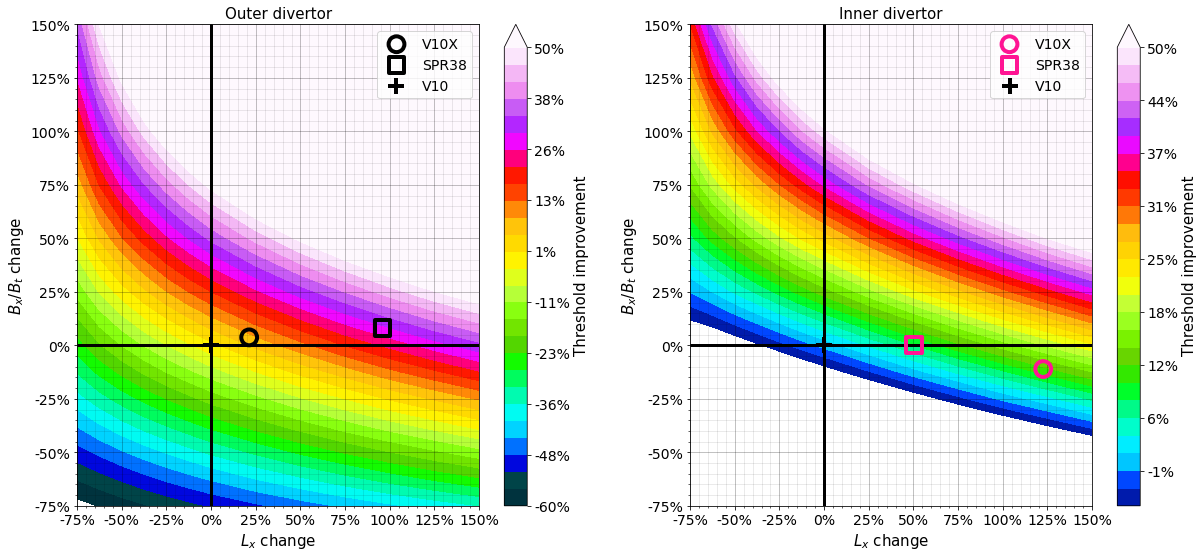

In [25]:
arr = dict()
scan = store
arr["ou"] = make_arrays(scan["ou"], list_BxBt_scales, list_Lc_scales, cut = False)
arr["iu"] = make_arrays(scan["iu"], list_BxBt_scales, list_Lc_scales, cut = False)

windowmin_outer = (-(arr["ou"]["window_ratio_base"] - 1) / arr["ou"]["window_ratio_base"])[0]
windowmin_inner = (-(arr["iu"]["window_ratio_base"] - 1) / arr["iu"]["window_ratio_base"])[0]

vmin_outer = ((arr["ou"]["threshold_base"] / arr["ou"]["window_ratio_base"]) / arr["ou"]["threshold_base"] -1)[0]

vmin_inner = ((arr["iu"]["threshold_base"] / arr["iu"]["window_ratio_base"])  / arr["iu"]["threshold_base"] -1)[0]

fig, axes = plt.subplots(1,2, figsize = (18,9))
fig.tight_layout(pad=5)

cmap = copy.copy(plt.get_cmap("gist_ncar"))

# levels = np.linspace(0, 3.0e19,22)
# levels = np.arange(-0.5, 0.55, 0.05)

ax = axes[0]
y = 1/(arr["ou"]["threshold_norm"]+1)-1

levels = np.linspace(-0.6, 0.5, 28)
vmin = levels[0]
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, y, levels = levels, cmap = cmap, vmin = vmin_outer, zorder = 0,  extend = "max")
cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Threshold improvement", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
ax.set_title("Outer divertor", fontsize = 15)

# [Lx][BxBt]
ax.scatter([1.213-1], [1.037-1], marker = "o", facecolor = "None", edgecolor = "black", s = 250, linewidth = 4, label = "V10X", zorder = 100)
ax.scatter([1.959-1], [1.080-1], marker = "s", facecolor = "None", edgecolor = "black", s = 250, linewidth = 4, label = "SPR38", zorder =100)
ax.scatter([0], [0], marker = "+", facecolor = "black", edgecolor = "black", s = 250, linewidth = 4, label = "V10", zorder = 100)


norm = mpl.colors.Normalize(vmin=-1, vmax = 2)

ax = axes[1]
# levels = np.linspace(-0.05, 0.5, 29)
levels = np.linspace(-0.05, 0.5, 27)
y = 1/(arr["iu"]["threshold_norm"]+1)-1
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, y, levels = levels, cmap = cmap, zorder = 0, vmin = vmin_inner,  extend = "max")
# cs.set_clim(-0.5,2)
# cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, patch_array(arr["iu"]["window"],percentile_threshold = 94), levels = 22, cmap = cmap, zorder = 0, vmin = 1)
cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Threshold improvement", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
ax.set_title("Inner divertor", fontsize = 15)
    
# [Lx][BxBt]
ax.scatter([2.226-1], [0.889-1], marker = "o", facecolor = "None", edgecolor = "deeppink", s = 250, linewidth = 4, label = "V10X", zorder = 100)
ax.scatter([1.501-1], [1-1], marker = "s", facecolor = "None", edgecolor = "deeppink", s = 250, linewidth = 4, label = "SPR38", zorder =100)
ax.scatter([0], [0], marker = "+", facecolor = "black", edgecolor = "black", s = 250, linewidth = 4, label = "V10", zorder = 0)

crosshair_color = "black"
for ax in axes:

    ax.set_xlim(-0.75,1.5)
    ax.set_ylim(-0.75,1.5)
    # ax.scatter(0,0, marker = "o", s = 200, facecolor = "black", linewidth = 3, color = crosshair_color)
    ax.hlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
    ax.vlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
    ax.grid(color = "black", alpha = 0.3, which = "major")
    ax.grid(color = "black", alpha = 0.1, which = "minor")
    ax.set_xlabel("$L_x$ change", fontsize = 15)
    ax.set_ylabel("$B_x/B_t$ change", fontsize = 15)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.legend(loc="upper right")

